# Vision Transformer from Scratch

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data

In [3]:
# Download dataset (MNIST)
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
val_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)


100%|██████████| 9.91M/9.91M [00:02<00:00, 4.81MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.21MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.9MB/s]


In [4]:
img_size = 28
num_channels = 1
patch_size = 7
num_patches = (img_size // patch_size) ** 2
batch_size = 64  # batch size means number of images
token_dim = 32
num_heads = 4
transformer_blocks = 4 #L
num_classes = 10
mlp_hidden_dim = 4 * token_dim
learning_rate = 3e-4
epochs = 5

In [5]:
train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## 1. Patch Embedding



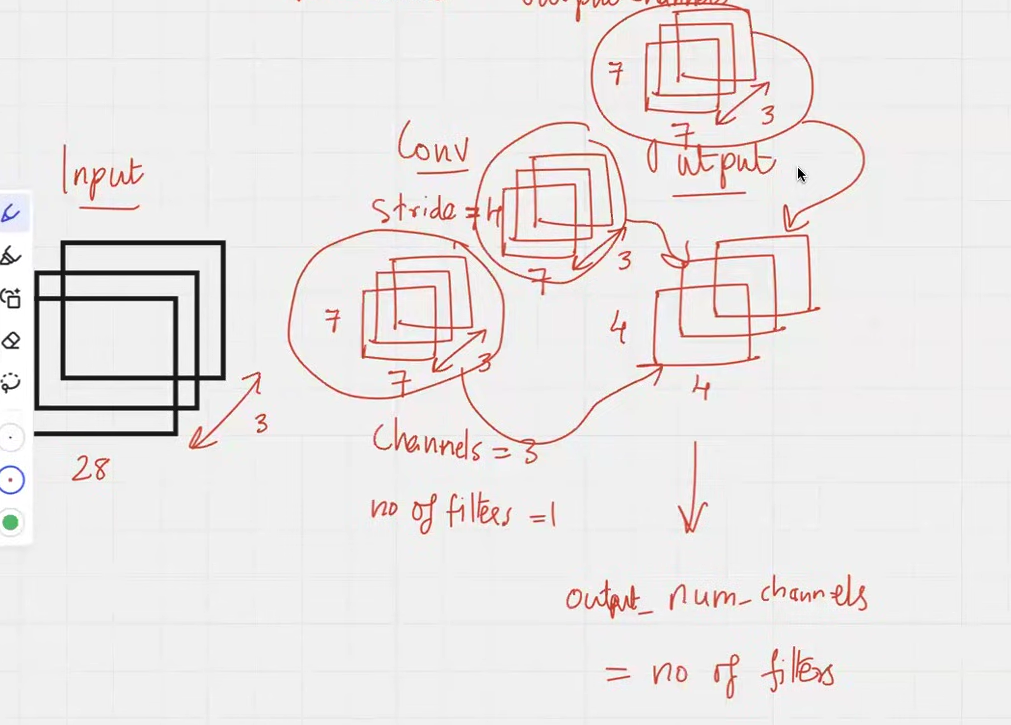

`[B, num_channels, H, W] -> [B, num_patches, token_dim]`

- Conv2D:
  - `[input_channels, output_channels, pacth_size, pacth_size] == (1, 32, 7, 7)`
  - 4x4 patches == 16 patches
  - Present each patch as 32 dim vector: `(num_channels, W, H) == (32, 1, 1)`

In [19]:
class PatchEmbedding(nn.Module):
  def __init__(self):
    super(PatchEmbedding, self).__init__()

    self.patch_embed = nn.Conv2d(
        in_channels=num_channels, # Corrected from img_size to num_channels
        out_channels=token_dim, # 32 -> each patch convert to 32 dimentional vector
        kernel_size=patch_size, # 7
        stride=patch_size, # 7
        padding='valid'
    )

  def forward(self, x): # x -> (64, 1, 28, 28)
    x = self.patch_embed(x) # [B, C, num_patches, num_patches] -> [54, 32, 4, 4]
    x = x.flatten(2) # [54, 32, 16]
    x = x.transpose(1, 2) # [54, 16, 32]
    return x

## 2. Transformer Encoder

In [7]:
class TransformerEncoder(nn.Module):
  def __init__(self):
    super(TransformerEncoder, self).__init__()

    self.layernorm1 = nn.LayerNorm(token_dim)
    self.layernorm2 = nn.LayerNorm(token_dim)

    self.multihead_attention = nn.MultiheadAttention(
        embed_dim=token_dim,
        num_heads=num_heads,
    )
    self.mlp = nn.Sequential(
        nn.Linear(token_dim, mlp_hidden_dim),
        nn.GELU(),
        nn.Linear(mlp_hidden_dim, token_dim),
    )

  def forward(self, x):

    residual1 = x
    x = self.layernorm1(x)
    x = self.multihead_attention(x, x, x)[0]
    x = residual1 + x

    residual2 = x
    x = self.layernorm2(x)
    x = self.mlp(x)
    x = x + residual2

    return x

## 3: MLP Classification Head

In [8]:
class MLPHead(nn.Module):
  def __init__(self):
    super(MLPHead, self).__init__()

    self.layernorm = nn.LayerNorm(token_dim)
    self.mlp = nn.Linear(token_dim, num_classes)

  def forward(self, x):
    x = self.layernorm(x)
    x = self.mlp(x)
    return x

In [16]:
class VisionTransformer(nn.Module):
  def __init__(self):
    super(VisionTransformer, self).__init__()

    self.patch_embedding = PatchEmbedding()
    self.cls_token = nn.Parameter(torch.randn(1, 1, token_dim))
    self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, token_dim))
    self.transformer_blocks = nn.Sequential(
        *[TransformerEncoder() for _ in range(transformer_blocks)]
    )
    self.mlp_head = MLPHead()

  def forward(self, x):
    x = self.patch_embedding(x)
    cls_token = self.cls_token.expand(x.shape[0], -1, -1) # [B, 1, embed_dim]
    x = torch.cat((cls_token, x), dim=1)
    x = x + self.pos_embedding
    x = self.transformer_blocks(x)
    x = x[:, 0]
    x = self.mlp_head(x)
    return x

In [17]:
device = torch.device('cuda')

model = VisionTransformer().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

In [18]:
for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = 0
    correct_train = 0
    total_train_samples = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total_train_samples += target.size(0)
        correct_train += (predicted == target).sum().item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train_samples

    # Validation
    model.eval()
    total_val_loss = 0
    correct_val = 0
    total_val_samples = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = loss_fn(output, target)

            total_val_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total_val_samples += target.size(0)
            correct_val += (predicted == target).sum().item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100 * correct_val / total_val_samples

    print(f'Epoch {epoch+1}/{epochs}: '
          f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}% | '
          f'Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')


Epoch 1/5: Train Loss: 2.3054, Train Accuracy: 10.71% | Val Loss: 2.3027, Val Accuracy: 10.28%
Epoch 2/5: Train Loss: 2.3038, Train Accuracy: 10.87% | Val Loss: 2.3034, Val Accuracy: 11.35%
Epoch 3/5: Train Loss: 2.3033, Train Accuracy: 11.03% | Val Loss: 2.3037, Val Accuracy: 10.28%
Epoch 4/5: Train Loss: 2.3031, Train Accuracy: 10.77% | Val Loss: 2.3034, Val Accuracy: 10.10%
Epoch 5/5: Train Loss: 2.3031, Train Accuracy: 10.87% | Val Loss: 2.3031, Val Accuracy: 10.28%


In [20]:
def predict_model(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for data, target in data_loader:
            data = data.to(device)
            output = model(data)

            _, predicted = torch.max(output.data, 1)
            all_labels.extend(target.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    return np.array(all_labels), np.array(all_predictions)

In [22]:
import numpy as np # Make sure numpy is imported if you haven't already

true_labels, predicted_labels = predict_model(model, val_loader, device)

# Now you can use true_labels and predicted_labels to calculate metrics like accuracy, precision, recall, confusion matrix, etc.
print(f"First 10 true labels: {true_labels[:10]}")
print(f"First 10 predicted labels: {predicted_labels[:10]}")

# Example of calculating accuracy:
accuracy = np.mean(true_labels == predicted_labels) * 100
print(f"Overall prediction accuracy: {accuracy:.2f}%")

First 10 true labels: [7 2 1 0 4 1 4 9 5 9]
First 10 predicted labels: [7 7 7 7 7 7 7 7 7 7]
Overall prediction accuracy: 10.28%
